<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Step25,-26" data-toc-modified-id="Step25,-26-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Step25, 26</a></span></li><li><span><a href="#Step27" data-toc-modified-id="Step27-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Step27</a></span></li><li><span><a href="#Step28~32" data-toc-modified-id="Step28~32-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Step28~32</a></span></li><li><span><a href="#Step33" data-toc-modified-id="Step33-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Step33</a></span></li></ul></div>

## Step25, 26

In [213]:
# 변수를 DOT 언어로 변환하는 함수
def _dot_var(v, verbose=False):
    dot_var = '{} [label="{}", color=orange, style=filled]\n'
    
    name = '' if v.name is None else v.name
    if verbose and v.data is not None:
        if v.name is not None:
            name += ''
        name += str(v.shape) + ' ' + str(v.dtype)
    return dot_var.format(id(v), name)

In [214]:
import sys
sys.path.append('..')

In [215]:
from dezero.core_simple import Variable

x = Variable(np.random.randn(2, 3))
x.name = 'x'

print(_dot_var(x))
print(_dot_var(x, verbose=True))

140515753892176 [label="x", color=orange, style=filled]

140515753892176 [label="x(2, 3) float64", color=orange, style=filled]



In [216]:
# 함수를 DOT 언어로 변환하는 함수
def _dot_func(f):
    # 함수 네이밍 작성
    dot_func = '{} [label="{}", color=lightblue, style=filled, shape=box]\n'
    txt = dot_func.format(id(f), f.__class__.__name__)
    
    # 변수 - 함수 간의 edge 연결
    dot_edge = '{} -> {}\n'
    # 함수가 캐싱해둔 입력 변수들을 활용해서 '입력변수 -> 함수' edge 연결
    for x in f.inputs:
        txt += dot_edge.format(id(x), id(f))
    # 함수가 캐싱해둔 출력 변수들을 활용해서 '함수 -> 출력변수' edge 연결
    for y in f.outputs:
        txt += dot_edge.format(id(f), id(y()))
    return txt

In [217]:
from dezero.core_simple import Variable

x0 = Variable(np.array(1.0))
x1 = Variable(np.array(1.0))
y = x0 + x1

txt = _dot_func(y.creator)
print(txt)

140515740281168 [label="Add", color=lightblue, style=filled, shape=box]
140515735010448 -> 140515740281168
140515754729424 -> 140515740281168
140515740281168 -> 140515708177232



In [218]:
# 이제 역전파 추적 방식과 유사한 방법으로 계산 그래프 그려보기
def get_dot_graph(output, verbose=True):
    txt = ''
    funcs = []
    seen_sets = set()
    
    def add_func(f):
        if f not in seen_sets:
            funcs.append(f)
            seen_sets.add(f)
    # 최종 출력변수를 만들어낸 마지막 함수 넣어두기
    add_func(output.creator)
    # 최종 출력변수에 대해서 계산 그래프 그리기 시작!
    txt = _dot_var(output, verbose)
    
    while funcs:
        f = funcs.pop()
        # 출력변수를 만들어낸 함수에 대해서 계산 그래프 그리기
        txt += _dot_func(f)
        # 함수의 입력변수들에 대해서 계산 그래프 그리기
        for x in f.inputs:
            txt += _dot_var(x, verbose)
            
            # 입력변수의 creator 함수가 있으면 계속!(없다는 것은 말단 입력변수까지 도달했음을 의미)
            if x.creator is not None:
                add_func(x.creator)
    # print('diagraph g {\n' + txt + '}')
    return 'digraph g {\n' + txt + '}'

In [219]:
from dezero.core_simple import Variable

x0 = Variable(np.array(2.0))
x1 = Variable(np.array(5.0))
y = x0 * x1

x0.name = 'x0'
x1.name = 'x1'
y.name = 'y'

dot = get_dot_graph(y, verbose=True)
dot

'digraph g {\n140515762491664 [label="y() float64", color=orange, style=filled]\n140515761518032 [label="Mul", color=lightblue, style=filled, shape=box]\n140515761516688 -> 140515761518032\n140515761517904 -> 140515761518032\n140515761518032 -> 140515762491664\n140515761516688 [label="x0() float64", color=orange, style=filled]\n140515761517904 [label="x1() float64", color=orange, style=filled]\n}'

In [222]:
# 이미지 변환까지 한번에 하도록 하기!
import os
import subprocess

def plot_dot_graph(output, verbose=True, to_file='graph.png'):
    # 1. 그래프를 DOT 언어로 표현한 문자열 얻기
    dot_graph = get_dot_graph(output, verbose)
    
    # 2. 문자열을 .dot 확장자 파일로 write
    tmp_dir = os.path.join(os.path.expanduser('~/Desktop/gitrepo/DeepLearningOnlyNumpy/season3'), 'dezero')
    if not os.path.exists(tmp_dir):
        os.mkdir(tmp_dir)
    graph_path = os.path.join(tmp_dir, 'tmp_graph.dot')
    
    with open(graph_path, 'w') as f:
        f.write(dot_graph)
    
    # 3. .dot 파일을 .png 확장자로 변경하는 cmd 명령어 실행
    extension = os.path.splitext(to_file)[1][1:]   # 확장자 기준(.)으로 경로 분할해줌!
    filename = os.path.join(tmp_dir, to_file)
    cmd = 'dot {} -T {} -o {}'.format(graph_path, extension, filename)
    subprocess.run(cmd, shell=True)
    
    # 대화형 인터프리터에서 그림 출력하도록 하기
    try:
        from IPython import display
        return display.Image(filename=filename)
    except:
        pass

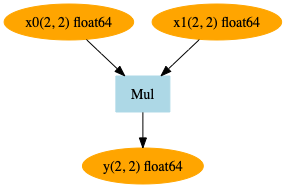

In [223]:
from dezero.core_simple import Variable

x0 = Variable(np.random.randn(2, 2))
x1 = Variable(np.random.randn(2, 2))
y = x0 * x1

x0.name = 'x0'
x1.name = 'x1'
y.name = 'y'

dot = plot_dot_graph(y, verbose=True)
dot

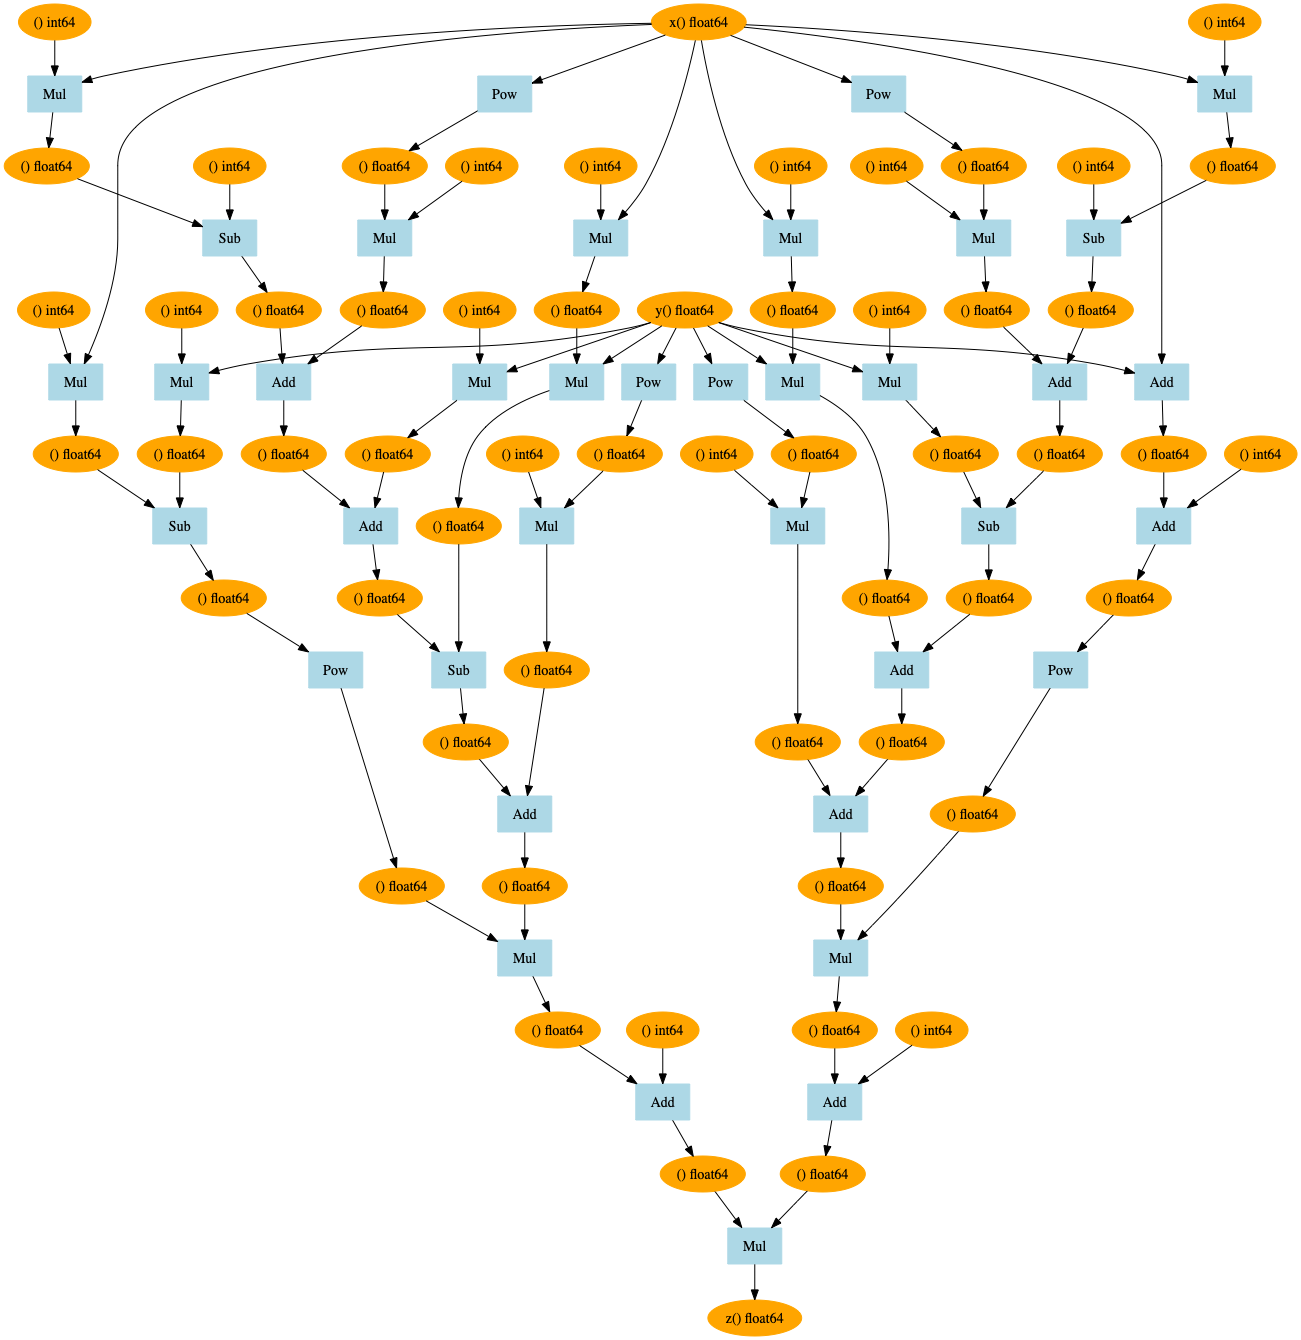

In [226]:
import numpy as np
from dezero import Variable

def goldstein(x, y):
    z = (1 + (x + y + 1)**2 * (19 - 14*x + 3*x**2 - 14*y + 6*x*y + 3*y**2)) * \
        (30 + (2*x - 3*y)**2 * (18 - 32*x + 12*x**2 + 48*y - 36*x*y + 27*y**2))
    return z

x = Variable(np.array(1.0))
y = Variable(np.array(1.0))
z = goldstein(x, y)
z.backward()

x.name = 'x'
y.name = 'y'
z.name = 'z'

plot_dot_graph(output=z, verbose=True, to_file='graph.png')

## Step27

In [4]:
import sys
sys.path.append('..')

In [11]:
# Sin 함수 클래스 정의
import numpy as np
from dezero import Function


class Sin(Function):
    def forward(self, x):
        y = np.sin(x)
        return y
    
    def backward(self, gy):
        x = self.inputs[0].data
        gx = np.cos(x) * gy
        return gx
    
def sin(x):
    return Sin()(x)

In [13]:
from dezero import Variable

x = Variable(np.array(np.pi/4))
y = sin(x)
y.backward()

flag = np.cos(np.pi/4)

print(y.data) # sin(pi/4)
print(x.grad) # cos(pi/4)
print(flag)

0.7071067811865475
0.7071067811865476
0.7071067811865476


In [18]:
# 테일러 급수
import math

def taylor_sin(x, threshold=0.0001):
    # y(sin(x)의 값)의 초기값
    y = 0 
    for i in range(int(1e5)):
        c = (-1) ** i / math.factorial(2*i + 1)
        t = c * x ** (2*i + 1)
        y = y + t
        if abs(t.data) < threshold:
            break
    return y

In [23]:
# 테일러 급수
import math
from dezero import Variable

def taylor_sin(x, threshold=0.0001):
    # y(sin(x)의 값)의 초기값
    y = 0 
    for i in range(int(1e5)):
        c = (-1) ** i / math.factorial(2*i + 1)
        t = c * x ** (2*i + 1)
        y = y + t
        if abs(t.data) < threshold:
            break
    return y

# Test
x = Variable(np.array(np.pi/4))
y = taylor_sin(x)
y.backward()

print(y.data)
print(x.grad)
print(np.cos(np.pi/4))

0.7071064695751781
0.7071032148228457
0.7071067811865476


In [27]:
from dezero import Variable
import numpy as np


def rosenbrock(x0, x1):
    y = 100 * ((x1 - x0**2) ** 2) + (1 - x0) ** 2
    return y

x0 = Variable(np.array(0.0))
x1 = Variable(np.array(2.0))
y = rosenbrock(x0, x1)
y.backward()

print(x0.grad, x1.grad) # (-2.0, 400.0)

-2.0 400.0


In [28]:
from dezero import Variable
import numpy as np


def rosenbrock(x0, x1):
    y = 100 * ((x1 - x0**2) ** 2) + (1 - x0) ** 2
    return y

x0 = Variable(np.array(0.0))
x1 = Variable(np.array(2.0))
lr = 0.001
iters = 1000

for i in range(iters):
    print(x0, x1)
    
    y = rosenbrock(x0, x1)
    
    x0.clear_grad()
    x1.clear_grad()
    
    y.backward()
    
    x0.data -= lr * x0.grad
    x1.data -= lr * x1.grad

variable(0.0) variable(2.0)
variable(0.002) variable(1.6)
variable(0.0052759968) variable(1.2800008)
variable(0.009966698110960038) variable(1.0240062072284468)
variable(0.01602875299014943) variable(0.8192248327970044)
variable(0.02324750923068761) variable(0.6554312504220874)
variable(0.031290846214210376) variable(0.5244530896747561)
variable(0.039780241951514035) variable(0.41975829515116514)
variable(0.04835473570612382) variable(0.3361231296508763)
variable(0.05671405943493354) variable(0.26936613981374286)
variable(0.06463840226323121) variable(0.2161362087585121)
variable(0.07198937826156711) variable(0.17374459161623834)
variable(0.07869927242171229) variable(0.14003216740948807)
variable(0.08475507379959696) variable(0.11326444902353183)
variable(0.0901819257435144) variable(0.0920482437257805)
variable(0.09502862514911821) variable(0.07526515092678615)
variable(0.09935624532071949) variable(0.062018208660975245)
variable(0.10322996680416148) variable(0.05158889962562639)
var

variable(0.6172469822815506) variable(0.37911826252124836)
variable(0.6175494112086666) variable(0.37949337744413486)
variable(0.6178514225831375) variable(0.37986815701214205)
variable(0.6181530173875027) variable(0.380242601687315)
variable(0.618454196600904) variable(0.38061671193090685)
variable(0.6187549611991012) variable(0.3809904882033794)
variable(0.6190553121544876) variable(0.38136393096440374)
variable(0.6193552504361048) variable(0.381737040672861)
variable(0.6196547770096585) variable(0.38210981778684283)
variable(0.6199538928375329) variable(0.3824822627636522)
variable(0.620252598878806) variable(0.382854376059804)
variable(0.6205508960892646) variable(0.3832261581310258)
variable(0.6208487854214191) variable(0.3835976094322585)
variable(0.6211462678245181) variable(0.38396873041765706)
variable(0.621443344244563) variable(0.38433952154059126)
variable(0.6217400156243229) variable(0.3847099832536463)
variable(0.6220362829033488) variable(0.3850801160086237)
variable(0.6

In [29]:
import numpy as np
from dezero import Variable

# 4차항 함수
def f(x):
    y = x ** 4 - 2 * x ** 2
    return y

# 4차항 함수를 2차 미분한 도함수
def gx2(x):
    return 12 * x ** 2 - 4

x = Variable(np.array(2.0))
iters = 10

# 뉴턴 메소드로 x 갱신
for i in range(iters):
    print(i, x)
    
    y = f(x)
    x.clear_grad()
    y.backward()
    
    x.data -= x.grad / gx2(x.data)

0 variable(2.0)
1 variable(1.4545454545454546)
2 variable(1.1510467893775467)
3 variable(1.0253259289766978)
4 variable(1.0009084519430513)
5 variable(1.0000012353089454)
6 variable(1.000000000002289)
7 variable(1.0)
8 variable(1.0)
9 variable(1.0)


## Step28~32
- 고차미분 이론/구현 설명 내용으로 실습 코드 X

## Step33

In [1]:
import sys
sys.path.append('..')

In [2]:
import numpy as np
from dezero import Variable

def f(x):
    y = x ** 4 - 2 * x ** 2
    return y

x = Variable(np.array(2.0))
y = f(x)

# 1차 미분 수행 및 미분값
y.backward(use_heap=True, create_graph=True)
print(x.grad) 

gx = x.grad
# 2차 미분 수행 및 미분값 -> 그런데 2차미분 값은 44임. 왜 68? 이유는 1차미분값에 2차미분값이 더해졌기 때문..
# -> 따라서 1차,2차 미분 사이에 미분값 초기화 작업 추가해야 함
gx.backward()
print(x.grad)

variable(24.0)
variable(68.0)


In [3]:
import numpy as np
from dezero import Variable

def f(x):
    y = x ** 4 - 2 * x ** 2
    return y

x = Variable(np.array(2.0))
y = f(x)

# 1차 미분 수행 및 미분값
y.backward(use_heap=True, create_graph=True)
print(x.grad)

gx = x.grad
# 2차 미분 수행 및 미분값
x.clear_grad()
gx.backward()
print(x.grad)

variable(24.0)
variable(44.0)


In [4]:
# 뉴턴 메소드를 활용한 최적화 
import numpy as np
from dezero import Variable

def f(x):
    y = x ** 4 - 2 * x ** 2
    return y

x = Variable(np.array(2.0))
iters = 10

for i in range(iters):
    print(i, x)
    
    y = f(x)
    x.clear_grad()
    
    # 1차 미분값
    y.backward(use_heap=True, create_graph=True)
    gx = x.grad
    x.clear_grad()
    
    # 2차 미분값
    gx.backward()
    gx2 = x.grad
    
    x.data -= gx.data / gx2.data

0 variable(2.0)
1 variable(1.4545454545454546)
2 variable(1.1510467893775467)
3 variable(1.0253259289766978)
4 variable(1.0009084519430513)
5 variable(1.0000012353089454)
6 variable(1.000000000002289)
7 variable(1.0)
8 variable(1.0)
9 variable(1.0)


In [13]:
# Dezero의 Sin, Cos 고차미분 수행하기
import numpy as np
from dezero import Variable
from dezero import functions as F

x = Variable(np.array(1.0))
y = F.sin(x)

# 최초 1차 미분 수행
y.backward(use_heap=True, create_graph=True)
print('1차 미분값:', x.grad)
print()

# 2,3,4차 미분 수행
for i in range(3):
    gx = x.grad
    x.clear_grad()
    gx.backward(create_graph=True)
    print(f'{i+2}차 미분값:', x.grad)

1차 미분값: variable(0.5403023058681398)

2차 미분값: variable(-0.8414709848078965)
3차 미분값: variable(-0.5403023058681398)
4차 미분값: variable(0.8414709848078965)


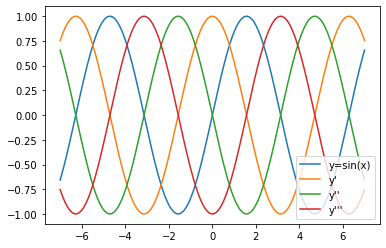

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from dezero import Variable
from dezero import functions as F

x = Variable(np.linspace(-7, 7, 200))
y = F.sin(x)

# 1차 미분 수행
y.backward(use_heap=True, create_graph=True)

logs = [y.data]

for i in range(3):
    logs.append(x.grad.data)  # 미분값 = 역전파를 하나의 순전파 그래프로 보았을 때의 y값이잖아!
    gx = x.grad
    # n차 미분 수행
    x.clear_grad()
    gx.backward(use_heap=True, create_graph=True)
    
# 시각화
labels = ["y=sin(x)", "y'", "y''", "y'''"]
for i, _ in enumerate(logs):
    plt.plot(x.data, logs[i], label=labels[i])
plt.legend(loc='lower right')
plt.show()

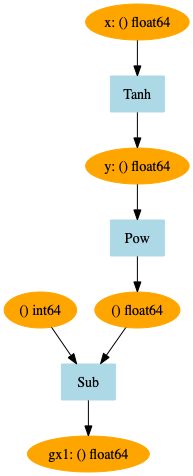

In [6]:
# Tanh 함수 추가한 후 순전파가 아닌 미분 즉, 역전파의 계산 그래프 시각화
import sys
sys.path.append('..')
import numpy as np
from dezero import Variable
from dezero import functions as F
from dezero.utils import plot_dot_graph

x = Variable(np.array(1.0))
y = F.tanh(x)
x.name = 'x'
y.name = 'y'
# 1차 미분 수행
y.backward(use_heap=True, create_graph=True)

iters = 0

for i in range(iters):
    gx = x.grad
    x.clear_grad()
    gx.backward(use_heap=True, create_graph=True)

# 계산 그래프 시각화
gx = x.grad
gx.name = 'gx' + str(iters+1)
plot_dot_graph(gx, verbose=True, to_file='graph2.png')

In [11]:
# Tanh 함수 추가한 후 순전파가 아닌 미분 즉, 역전파의 계산 그래프 시각화
import sys
sys.path.append('..')
import numpy as np
from dezero import Variable
from dezero import functions as F
from dezero.utils import plot_dot_graph

x = Variable(np.array(1.0))
y = F.tanh(x)
x.name = 'x'
y.name = 'y'
# 1차 미분 수행
y.backward(use_heap=True, create_graph=True)
print(x.grad)

# 2차 미분 수행
gx = x.grad
x.clear_grad()
gx.backward(use_heap=True, create_graph=True)
print(x.grad)

variable(0.41997434161402614)
variable(0.41997434161402614)


1차 미분값: variable(0.41997434161402614)
2차 미분값: variable(0.41997434161402614)


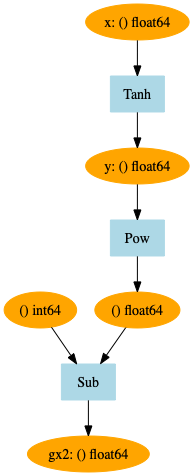

In [20]:
import numpy as np
from dezero import Variable
from dezero.utils import plot_dot_graph
import dezero.functions as F

x = Variable(np.array(1.0))
y = F.tanh(x)
x.name = 'x'
y.name = 'y'

# 1차 미분
y.backward(create_graph=True)
gx = x.grad
print('1차 미분값:', x.grad)

# 2차 미분
x.clear_grad()
gx.backward(create_graph=True)
gx2 = x.grad
print('2차 미분값:', x.grad)

# 계산 그래프 시각화
gx2.name = 'gx2'
plot_dot_graph(gx2, verbose=True, to_file='graph2.png')